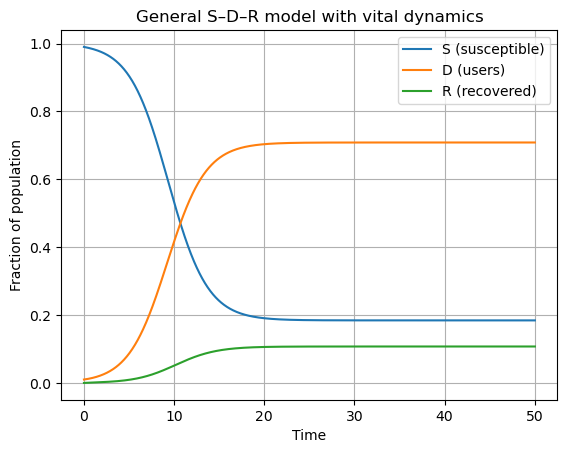

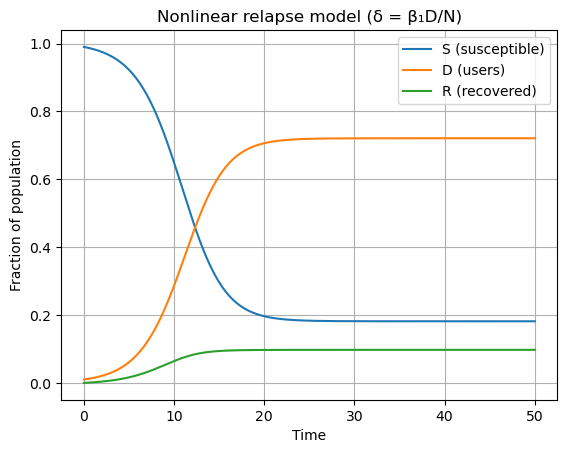

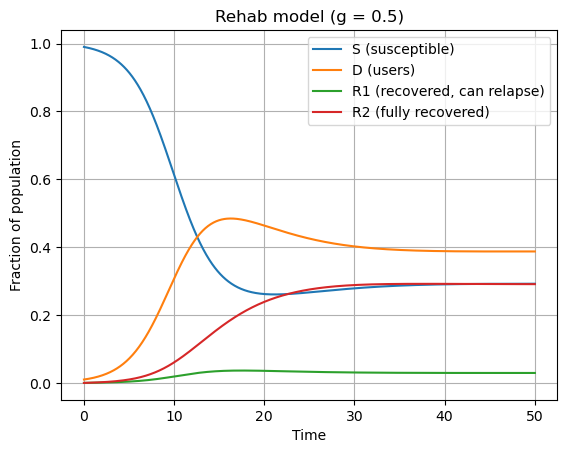

In [3]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# -------------------------------
# Common parameters (from paper)
# -------------------------------
params = {
    "beta": 0.625,   # effective influence rate β
    "gamma": 0.15,   # recovery rate γ
    "delta": 0.89,   # relapse rate δ (used in linear relapse & rehab)
    "mu": 0.10,      # per–capita death rate μ
    "beta1": 1.4,    # relapse influence β1 (nonlinear relapse model, from paper)
    "N": 1.0,        # total population (use 1.0 for fractions; or set to actual N)
    "g": 0.5         # effectiveness of rehab program (0 = none, 1 = perfect)
}

# ======================================================
# 1) General S–D–R model with vital dynamics (eqs. 1–3)
#    dS/dt = μN - β S D / N - μS
#    dD/dt = β S D / N - γD + δR - μD
#    dR/dt = γD - δR - μR
# ======================================================

def rhs_general_vital(t, y, p):
    S, D, R = y
    beta, gamma, delta, mu, N = p["beta"], p["gamma"], p["delta"], p["mu"], p["N"]

    dSdt = mu * N - beta * S * D / N - mu * S
    dDdt = beta * S * D / N - gamma * D + delta * R - mu * D
    dRdt = gamma * D - delta * R - mu * R

    return [dSdt, dDdt, dRdt]

# ======================================================
# 2) Nonlinear relapse model (δ = β1 D / N)
#    dS/dt = μN - β S D / N - μS
#    dD/dt = β S D / N - γD + β1 R D / N - μD
#    dR/dt = γD - β1 R D / N - μR
# ======================================================

def rhs_nonlinear_relapse(t, y, p):
    S, D, R = y
    beta, beta1, gamma, mu, N = p["beta"], p["beta1"], p["gamma"], p["mu"], p["N"]

    dSdt = mu * N - beta * S * D / N - mu * S
    dDdt = beta * S * D / N - gamma * D + beta1 * R * D / N - mu * D
    dRdt = gamma * D - beta1 * R * D / N - mu * R

    return [dSdt, dDdt, dRdt]

# ======================================================
# 3) Rehab model with effectiveness g
#    Classes: S (susceptible), D (smoker), R1 (recovered, can relapse),
#             R2 (fully recovered, no relapse)
#
#    dS/dt  = μN - β S D / N - μS
#    dD/dt  = β S D / N - γD + δ R1 - μD
#    dR1/dt = (1 - g) γD - δ R1 - μR1
#    dR2/dt = g γD - μR2
#
#    with S + D + R1 + R2 = N
# ======================================================

def rhs_rehab(t, y, p):
    D, R1, R2 = y
    beta, gamma, delta, mu, N, g = (
        p["beta"], p["gamma"], p["delta"], p["mu"], p["N"], p["g"]
    )

    # Recover S from conservation S + D + R1 + R2 = N
    S = N - (D + R1 + R2)

    dSdt  = mu * N - beta * S * D / N - mu * S
    dDdt  = beta * S * D / N - gamma * D + delta * R1 - mu * D
    dR1dt = (1 - g) * gamma * D - delta * R1 - mu * R1
    dR2dt = g * gamma * D - mu * R2

    # We usually only integrate (D, R1, R2), but you can integrate S too if you like
    return [dDdt, dR1dt, dR2dt]

# ======================================================
# Helper: generic solver + plotting
# ======================================================

def simulate_general_vital(t_span=(0, 50), y0=(0.99, 0.01, 0.0), p=params):
    sol = solve_ivp(
        rhs_general_vital, t_span, y0, args=(p,),
        dense_output=True, max_step=0.1
    )
    t = np.linspace(t_span[0], t_span[1], 1000)
    S, D, R = sol.sol(t)

    plt.figure()
    plt.plot(t, S, label="S (susceptible)")
    plt.plot(t, D, label="D (users)")
    plt.plot(t, R, label="R (recovered)")
    plt.xlabel("Time")
    plt.ylabel("Fraction of population")
    plt.title("General S–D–R model with vital dynamics")
    plt.legend()
    plt.grid(True)
    plt.show()

    return t, np.vstack((S, D, R))


def simulate_nonlinear_relapse(t_span=(0, 50), y0=(0.99, 0.01, 0.0), p=params):
    sol = solve_ivp(
        rhs_nonlinear_relapse, t_span, y0, args=(p,),
        dense_output=True, max_step=0.1
    )
    t = np.linspace(t_span[0], t_span[1], 1000)
    S, D, R = sol.sol(t)

    plt.figure()
    plt.plot(t, S, label="S (susceptible)")
    plt.plot(t, D, label="D (users)")
    plt.plot(t, R, label="R (recovered)")
    plt.xlabel("Time")
    plt.ylabel("Fraction of population")
    plt.title("Nonlinear relapse model (δ = β₁D/N)")
    plt.legend()
    plt.grid(True)
    plt.show()

    return t, np.vstack((S, D, R))


def simulate_rehab(t_span=(0, 50), y0=(0.01, 0.0, 0.0), p=params):
    """
    y0 = (D0, R10, R20); S0 is computed as N - (D0 + R10 + R20)
    """
    sol = solve_ivp(
        rhs_rehab, t_span, y0, args=(p,),
        dense_output=True, max_step=0.1
    )
    t = np.linspace(t_span[0], t_span[1], 1000)
    D, R1, R2 = sol.sol(t)
    S = p["N"] - (D + R1 + R2)

    plt.figure()
    plt.plot(t, S,  label="S (susceptible)")
    plt.plot(t, D,  label="D (users)")
    plt.plot(t, R1, label="R1 (recovered, can relapse)")
    plt.plot(t, R2, label="R2 (fully recovered)")
    plt.xlabel("Time")
    plt.ylabel("Fraction of population")
    plt.title(f"Rehab model (g = {p['g']})")
    plt.legend()
    plt.grid(True)
    plt.show()

    return t, np.vstack((S, D, R1, R2))


# ======================================================
# Example: run all three models
# ======================================================

if __name__ == "__main__":
    # General S–D–R
    simulate_general_vital()

    # Nonlinear relapse
    simulate_nonlinear_relapse()

    # Rehab model: start with 1% smokers
    simulate_rehab()


Using parameters: {'beta': 0.31172069825436405, 'gamma': 0.15, 'mu': 0.1, 'N': 1.0}


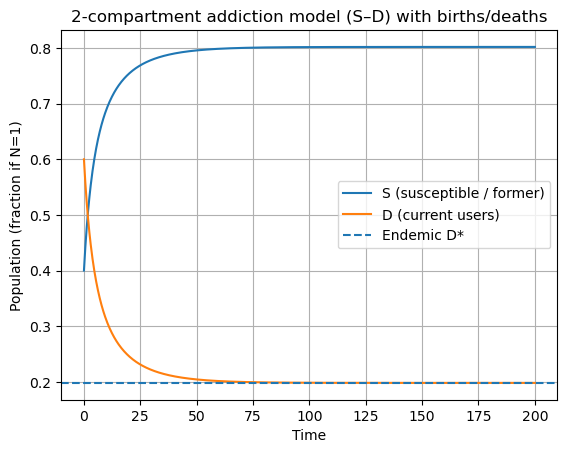

In [13]:
def rhs_addiction_SIS(t, y, p):
    """
    2-compartment addiction model with births and deaths:
      S: susceptible / former users
      D: current dependent users

    dS/dt = μN - β S D / N + γ D - μS
    dD/dt = β S D / N - γ D - μD
    """
    S, D = y
    beta = p["beta"]
    gamma = p["gamma"]
    mu    = p["mu"]
    N     = p["N"]

    dSdt = mu * N - beta * S * D / N + gamma * D - mu * S
    dDdt = beta * S * D / N - gamma * D - mu * D

    return [dSdt, dDdt]

def make_params_for_target_fraction(gamma=0.15, mu=0.10,
                                    target_fraction_users=0.198,
                                    N=1.0):
    """
    Choose beta so that the endemic equilibrium satisfies D*/N = target_fraction_users.
    beta = (gamma + mu) / (1 - f)
    """
    f = target_fraction_users
    beta = (gamma + mu) / (1.0 - f)
    return {"beta": beta, "gamma": gamma, "mu": mu, "N": N}

def simulate_addiction_SIS(t_span=(0, 200), y0=(0.4, 0.6),
                           params=None):
    if params is None:
        params = make_params_for_target_fraction()

    print("Using parameters:", params)

    sol = solve_ivp(
        rhs_addiction_SIS,
        t_span,
        y0,
        args=(params,),
        dense_output=True,
        max_step=0.1
    )

    t = np.linspace(t_span[0], t_span[1], 1000)
    S, D = sol.sol(t)

    plt.figure()
    plt.plot(t, S, label="S (susceptible / former)")
    plt.plot(t, D, label="D (current users)")
    plt.axhline(params["N"] * (1.0 - (params["gamma"] + params["mu"]) / params["beta"]),
                linestyle="--", label="Endemic D*")
    plt.xlabel("Time")
    plt.ylabel("Population (fraction if N=1)")
    plt.title("2-compartment addiction model (S–D) with births/deaths")
    plt.legend()
    plt.grid(True)
    plt.show()

    return t, np.vstack((S, D))

if __name__ == "__main__":
    # Match CDC: ~19.8% users at equilibrium
    params = make_params_for_target_fraction(
        gamma=0.15,
        mu=0.10,
        target_fraction_users=0.198,
        N=1.0
    )
    simulate_addiction_SIS(params=params)


Using parameters: {'beta': 0.31172069825436405, 'gamma': 0.15, 'mu': 0.1, 'N': 1.0, 'alpha': 0.7}


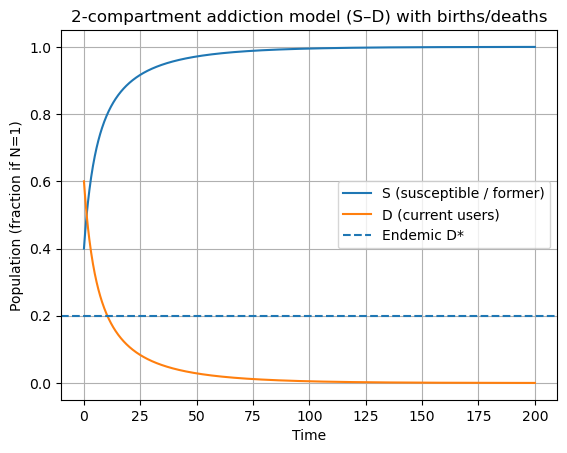

In [27]:
def rhs_addiction_SIS(t, y, p):
    """
    2-compartment addiction model with births, deaths, and a negativity parameter α:
      S: susceptible / former users
      D: current dependent users

    dS/dt = μN - α β S D / N + γ D - μS
    dD/dt = α β S D / N - γ D - μD
    """
    S, D = y
    alpha = p["alpha"]
    beta = p["beta"]
    gamma = p["gamma"]
    mu    = p["mu"]
    N     = p["N"]

    dSdt = mu * N - alpha * beta * S * D / N + gamma * D - mu * S
    dDdt = alpha * beta * S * D / N - gamma * D - mu * D

    return [dSdt, dDdt]

def make_params_for_target_fraction(gamma=0.15, mu=0.10,
                                    target_fraction_users=0.198,
                                    N=1.0, alpha=1.0):
    """
    Choose beta so that the endemic equilibrium satisfies D*/N = target_fraction_users.
    beta = (gamma + mu) / (1 - f)
    """
    f = target_fraction_users
    beta = (gamma + mu) / (1.0 - f)
    return {"beta": beta, "gamma": gamma, "mu": mu, "N": N, "alpha": alpha}

def simulate_addiction_SIS(t_span=(0, 200), y0=(0.4, 0.6),
                           params=None):
    """
    Run the addiction model simulation with given parameters
    """
    if params is None:
        params = make_params_for_target_fraction(alpha=0.8)  # Set alpha for reduced transition rate

    print("Using parameters:", params)

    sol = solve_ivp(
        rhs_addiction_SIS,
        t_span,
        y0,
        args=(params,),
        dense_output=True,
        max_step=0.1
    )

    t = np.linspace(t_span[0], t_span[1], 1000)
    S, D = sol.sol(t)

    plt.figure()
    plt.plot(t, S, label="S (susceptible / former)")
    plt.plot(t, D, label="D (current users)")
    plt.axhline(params["N"] * (1.0 - (params["gamma"] + params["mu"]) / params["beta"]),
                linestyle="--", label="Endemic D*")
    plt.xlabel("Time")
    plt.ylabel("Population (fraction if N=1)")
    plt.title("2-compartment addiction model (S–D) with births/deaths")
    plt.legend()
    plt.grid(True)
    plt.show()

    return t, np.vstack((S, D))


if __name__ == "__main__":
    # Match CDC: ~19.8% users at equilibrium, with added negativity (α < 1)
    params = make_params_for_target_fraction(
        gamma=0.15,
        mu=0.10,
        target_fraction_users=0.198,
        N=1.0,
        alpha=0.7  # Adjust this value based on the desired negativity effect
    )
    simulate_addiction_SIS(params=params)
